In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from adjustText import adjust_text
import shap
import os
import scipy
from pathlib import Path
from sklearn.metrics import mean_squared_error


/home/veror/Desktop/Tweet2Geo/venv_tweets/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# choose if using all the data or a subset

data = 'all' # all, elections

In [11]:
cwd = Path.cwd()
parent_dir = cwd.parent.parent

parent_dir

PosixPath('/home/veror/Desktop/Tweet2Geo/NEW Tweet2Geo')

In [12]:
# DATA FOR FIT

# countr info dataset
country_info = pd.read_csv(parent_dir / 'Data' / 'South America' / '0 gravity model' / 'pop_gdp SA.csv')

# population vector
country_pop = country_info['pop'].to_numpy()

# GDP vector
country_gdp = country_info['gdp'].to_numpy()

# GDP per capita vector
country_gdp_per_capita = (country_info['gdp'] / country_info['pop']).to_numpy()


# distances matrix
matrix_distance = pd.read_csv(parent_dir / 'Data' / 'South America' / '0 gravity model' / 'distances SA.csv')
matrix_distance = matrix_distance.drop(index=[0], columns=['lat_lon'])
matrix_distance = matrix_distance.apply(pd.to_numeric)
matrix_distance = matrix_distance.reset_index(drop=True)
matrix_distance.columns = matrix_distance.index

# countries pairs vector
migration_flows = pd.read_csv(parent_dir / 'Data' / 'South America' / '0 gravity model' / 'migration matrix SA.csv')
country_vector = []
for i in range(len(migration_flows)):
    for col in migration_flows.columns[1:]:
        country_vector.append(migration_flows.at[i, 'Unnamed: 0']+'-'+col)

# df for index
if data == 'all':
    # df for index
    df_flux_no_self = pd.read_csv(parent_dir / 'Data' / 'South America' / 'matrix_fluxes_0.5_no_self_loops.csv')
else:
    # df for index
    file = data + '_flux.csv'
    df_flux_no_self = pd.read_csv(parent_dir / 'Data analysis' / 'Topics' / 'topics_flux' / 'SA' / file)

### Model: gdp tot, distance, language, inverse migration

In [ ]:
column1 = 'Source gdp'
column2 = 'Target gdp'
column3 = 'Distance'
column4 = 'Language'
column5 = 'Migration'
column6 = 'flux_percentage_05'

# results dataframe
res_df = pd.DataFrame()

# flows
if data == 'all':
    normalized_flows = pd.read_csv(parent_dir / 'Data' / 'South America' / 'fluxes_0.5_norm_day okok.csv')
else:
    file = data + '_norm_flux.csv'
    normalized_flows = pd.read_csv(parent_dir / 'Data analysis' / 'Topics' / 'topics_flux' / 'SA' / file)#.drop(columns=['Unnamed: 0'])
normalized_flows = normalized_flows.apply(pd.to_numeric)#.drop(columns=['Unnamed: 0'])

# languages
lang_matrix = pd.read_csv(parent_dir / 'Data' / 'South America' / '0 gravity model' / 'languages_matrix_dummies.csv').drop(columns=['Unnamed: 0'])
lang_matrix.columns = df_flux_no_self.index
lang_matrix.index = df_flux_no_self.index

# migration flows
matr_migr = pd.read_csv(parent_dir / 'Data' / 'South America' / '0 gravity model' /'migration matrix SA trans.csv').drop(columns=['Unnamed: 0'])
matr_migr = matr_migr.fillna(-1)
matr_migr = matr_migr.replace(0, -1)
matr_migr.columns = df_flux_no_self.index
matr_migr.index = df_flux_no_self.index
matr_migr = matr_migr.apply(pd.to_numeric)

# create sub percentage flow vector
real_vector = []

# create vectors for columns
dist_vector = []
lang_vector = []
migr_vector = []
flow_vector = []
multiple_country_gdp = []
starting_gdp = np.repeat(country_gdp, 10)

for i in range(len(normalized_flows)):

    dist_vector += list(matrix_distance.loc[i])
    lang_vector += list(lang_matrix.loc[i])
    migr_vector += list(matr_migr.loc[i])
    flow_vector += list(normalized_flows.loc[i])
    multiple_country_gdp += list(country_gdp)

df_plot = pd.DataFrame({column1: starting_gdp, column2: multiple_country_gdp, column3: dist_vector, column4: lang_vector, column5: migr_vector, column6: flow_vector})

sub_plot = df_plot[(df_plot['flux_percentage_05'] > 0) & (df_plot['Distance'] > 0) & (df_plot['Language'] != 'menouno') & (df_plot['Migration'] > 0)]
sub_plot = pd.get_dummies(data=sub_plot)

# create df for residuals plot without migration
residual_df = pd.DataFrame()
residual_df['Source gdp'] = sub_plot['Source gdp']
residual_df['Target gdp'] = sub_plot['Target gdp']
residual_df['Distance'] = sub_plot['Distance']
residual_df['Language_2'] = sub_plot['Language_2']
residual_df['Language_1'] = sub_plot['Language_1']
residual_df['Migration'] = sub_plot['Migration']

# model
real_vector = list(sub_plot['flux_percentage_05'])
sub_plot['flux_percentage_05'] = np.log10(sub_plot['flux_percentage_05'])
sub_plot['Source gdp'] = np.log10(sub_plot['Source gdp'])
sub_plot['Target gdp'] = np.log10(sub_plot['Target gdp'])
sub_plot['Distance'] = np.log10(sub_plot['Distance'])
sub_plot['Migration'] = np.log10(sub_plot['Migration'])
y = sub_plot['flux_percentage_05']
X = sub_plot.drop(columns=['flux_percentage_05'])
mod = LinearRegression()
mod.fit(X, y)
print('R squared', mod.score(X, y))
print('intercept', mod.intercept_)
print('coefficients', mod.coef_)
res_df = res_df._append({'R squared': mod.score(X, y), 'Intercept': mod.intercept_, 'Coefficient 1 (Source gdp)': mod.coef_[0], 'Coefficient 2 (Target gdp)': mod.coef_[1], 'Coefficient 3 (dist)': mod.coef_[2], 'Coefficient 4 (Migration)': mod.coef_[3], 'Coefficient 5.1 (Language_2)': mod.coef_[4], 'Coefficient 4.2 (Language_1)': mod.coef_[5],  'Normalization factor': -mod.intercept_, '# points per fit': len(sub_plot)}, ignore_index=True)
extimated_flux_log = mod.predict(X)
residual = y - extimated_flux_log
residual_df['residuals'] = residual
residual_df['y'] = y

# compute AIC
rss = np.sum((y - extimated_flux_log)**2)
n = len(y)
k = X.shape[1]
# mean square error
mse = mean_squared_error(y, extimated_flux_log)
# log likelihood
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - extimated_flux_log) ** 2)
# AIC and BIC calculations
aic_simpler = 2 * k - 2 * log_likelihood
bic_simpler = np.log(n) * k - 2 * log_likelihood
print('AIC', aic_simpler)
print('BIC', bic_simpler)

file = 'fit_g1_g2_d_lang_m_trans_' + data + '.csv'
res_df.to_csv(parent_dir / 'Data analysis' / 'Gravity model' / 'SA' / file)

    Source gdp  Target gdp  Distance  Migration  flux_percentage_05  \
1    11.801246   10.634164  3.316919   5.626480            1.234083   
2    11.801246   12.283323  3.475943   4.692556            2.109144   
3    11.801246   11.501059  2.838886   5.332838            1.728933   
4    11.801246   11.536482  3.646985   3.940666            1.477121   
5    11.801246   11.026125  3.602486   2.983626            1.330993   
..         ...         ...       ...        ...                 ...   
94   11.683371   11.536482  2.927055   5.962726            1.659244   
95   11.683371   11.026125  3.219702   4.542302            1.342975   
96   11.683371   10.620368  3.540186   2.301030            0.497876   
97   11.683371   11.384947  3.306572   4.646590            1.160634   
98   11.683371   10.773201  3.657980   3.655042            0.400966   

    Language_1  Language_2  
1         True       False  
2        False        True  
3         True       False  
4         True       False  
5 

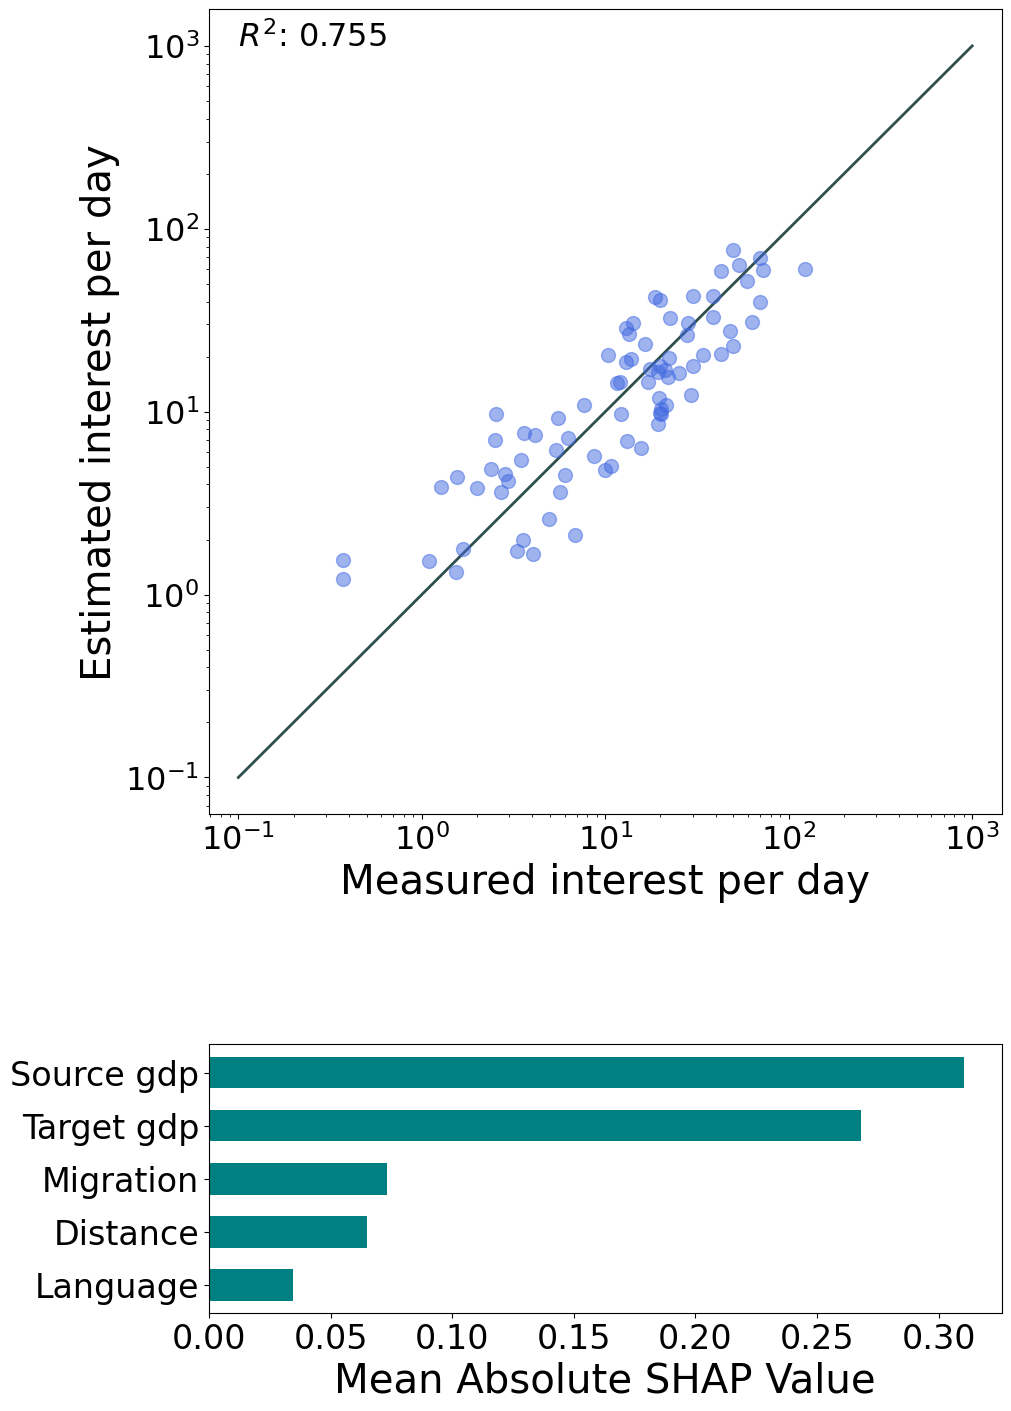

Index(['Source gdp', 'Target gdp', 'Migration', 'Distance', 'Language'], dtype='object')
[0.3103260265319255 0.2679152144505351 0.07340813241967019
 0.0648270166785627 0.03453067406819088]


In [ ]:
# params
AREA = 'SA'
low_bound = 0.1
high_bound = 1000
x = np.linspace(low_bound, high_bound, high_bound)

# shap values
masker = X  
explainer = shap.Explainer(mod, masker)
shap_values = explainer(X)
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

# Compute mean absolute SHAP value per feature
shap_mean = shap_df.abs().mean().sort_values(ascending=False)

# Create figure
fig = plt.figure(figsize=(10, 14), constrained_layout=True)  

gs = fig.add_gridspec(nrows=18, ncols=1)  #)
ax1 = fig.add_subplot(gs[:12, 0])
ax2 = fig.add_subplot(gs[14:, 0])

# First subplot
ext_vector = 10 ** extimated_flux_log

ax1.plot(x, x, color='darkslategray', alpha=1, linewidth=2.0)
ax1.loglog(real_vector, ext_vector, '.', color='royalblue', alpha=0.5, markersize=20)

ax1.text(low_bound, high_bound, r'$R^{2}$: ' + str(round(mod.score(X, y), 3)), size=23)

ax1.set_xlabel('Measured interest per day', fontsize=29)
ax1.set_ylabel('Estimated interest per day', fontsize=29)
ax1.tick_params(axis='both', labelsize=23)
ax1.set_aspect('equal', adjustable='datalim')

# Second subplot
bar_width = 0.6
new_shap_mean_index = shap_mean.index[0:5]
new_shap_mean_values = shap_mean.values[0:5]
new_shap_mean_index_list = list(new_shap_mean_index)
new_shap_mean_index_list[4] = 'Language'
new_shap_mean_index = pd.Index(new_shap_mean_index_list)
#ax2.barh(shap_mean.index[::-1], shap_mean.values[::-1], color='teal', height=bar_width)
ax2.barh(new_shap_mean_index[::-1], new_shap_mean_values[::-1], color='teal', height=bar_width)


ax2.set_xlabel('Mean Absolute SHAP Value', fontsize=29)
ax2.tick_params(axis='both', labelsize=24)

#plt.tight_layout()
file = 'g1_g2_d_lang_m_trans_' + data + f'_gravity_model_{AREA}.pdf'
fig.savefig(parent_dir / 'Data analysis' / 'Gravity model' / 'SA' / file, transparent=True, dpi = 300)
plt.show()

### Model: population, gdp per capita, distance, language, inverse migration

In [ ]:
column1 = 'Source gdp capita'
column2 = 'Target gdp capita'
column3 = 'Source population'
column4 = 'Target population'
column5 = 'Distance'
column6 = 'Language'
column7 = 'Migration'
column8 = 'flux_percentage_05'

# results dataframe
res_df = pd.DataFrame()

# flows
if data == 'all':
    normalized_flows = pd.read_csv(parent_dir / 'Data' / 'South America' / 'fluxes_0.5_norm_day okok.csv')
else:
    file = data + '_norm_flux.csv'
    normalized_flows = pd.read_csv(parent_dir / 'Data analysis' / 'Topics' / 'topics_flux' / 'SA' / file)
normalized_flows = normalized_flows.apply(pd.to_numeric)#.drop(columns=['Unnamed: 0'])

# languages
lang_matrix = pd.read_csv(parent_dir / 'Data' / 'South America' / '0 gravity model' / 'languages_matrix_dummies.csv').drop(columns=['Unnamed: 0'])
lang_matrix.columns = df_flux_no_self.index
lang_matrix.index = df_flux_no_self.index

# migration flows
matr_migr = pd.read_csv(parent_dir / 'Data' / 'South America' / '0 gravity model' /'migration matrix SA trans.csv').drop(columns=['Unnamed: 0'])
matr_migr = matr_migr.fillna(-1)
matr_migr = matr_migr.replace(0, -1)
matr_migr.columns = df_flux_no_self.index
matr_migr.index = df_flux_no_self.index
matr_migr = matr_migr.apply(pd.to_numeric)

# create sub percentage flow vector
real_vector = []

# create vectors for columns
dist_vector = []
lang_vector = []
migr_vector = []
flow_vector = []
multiple_country_gdp = []
starting_gdp = np.repeat(country_gdp_per_capita, 10)
multiple_country_pop = []
starting_pop = np.repeat(country_pop, 10)

for i in range(len(normalized_flows)):

    dist_vector += list(matrix_distance.loc[i])
    lang_vector += list(lang_matrix.loc[i])
    migr_vector += list(matr_migr.loc[i])
    flow_vector += list(normalized_flows.loc[i])
    multiple_country_gdp += list(country_gdp_per_capita)
    multiple_country_pop += list(country_pop)

df_plot = pd.DataFrame({column1: starting_gdp, column2: multiple_country_gdp, column3: starting_pop, column4: multiple_country_pop, column5: dist_vector, column6: lang_vector, column7: migr_vector, column8: flow_vector})

sub_plot = df_plot[(df_plot['flux_percentage_05'] > 0) & (df_plot['Distance'] > 0) & (df_plot['Language'] != 'menouno') & (df_plot['Migration'] > 0)]
sub_plot = pd.get_dummies(data=sub_plot)

# create df for residuals plot without migration
'''residual_df = pd.DataFrame()
residual_df['Source gdp capita'] = sub_plot['Source gdp capita']
residual_df['Target gdp capita'] = sub_plot['Target gdp capita']
residual_df['Distance'] = sub_plot['Distance']
residual_df['Language_2'] = sub_plot['Language_2']
residual_df['Language_1'] = sub_plot['Language_1']
residual_df['Migration'] = sub_plot['Migration']'''

# model
real_vector = list(sub_plot['flux_percentage_05'])
sub_plot['flux_percentage_05'] = np.log10(sub_plot['flux_percentage_05'])
sub_plot['Source gdp capita'] = np.log10(sub_plot['Source gdp capita'])
sub_plot['Target gdp capita'] = np.log10(sub_plot['Target gdp capita'])
sub_plot['Source population'] = np.log10(sub_plot['Source population'])
sub_plot['Target population'] = np.log10(sub_plot['Target population'])
sub_plot['Distance'] = np.log10(sub_plot['Distance'])
sub_plot['Migration'] = np.log10(sub_plot['Migration'])
y = sub_plot['flux_percentage_05']
X = sub_plot.drop(columns=['flux_percentage_05'])
mod = LinearRegression()
mod.fit(X, y)
print('R squared', mod.score(X, y))
print('intercept', mod.intercept_)
print('coefficients', mod.coef_)
res_df = res_df._append({'R squared': mod.score(X, y), 'Intercept': mod.intercept_, 'Coefficient 1 (Source gdp capita)': mod.coef_[0], 'Coefficient 2 (Target gdp capita)': mod.coef_[1], 'Coefficient 3 (Source population)': mod.coef_[2], 'Coefficient 4 (Target population)': mod.coef_[3], 'Coefficient 5 (dist)': mod.coef_[4], 'Coefficient 6 (Migration)': mod.coef_[5], 'Coefficient 7.1 (Language_2)': mod.coef_[6], 'Coefficient 7.2 (Language_1)': mod.coef_[7],  'Normalization factor': -mod.intercept_, '# points per fit': len(sub_plot)}, ignore_index=True)
extimated_flux_log = mod.predict(X)
residual = y - extimated_flux_log
residual_df['residuals'] = residual
residual_df['y'] = y

# compute AIC
rss = np.sum((y - extimated_flux_log)**2)
n = len(y)
k = X.shape[1]
# mean square error
mse = mean_squared_error(y, extimated_flux_log)
# log likelihood
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - extimated_flux_log) ** 2)
# AIC and BIC calculations
aic_complex = 2 * k - 2 * log_likelihood
bic_complex = np.log(n) * k - 2 * log_likelihood
print('AIC', aic_complex)
print('BIC', bic_complex)

file = 'fit_p1_p2_g1_g2_d_lang_m_trans_' + data + '.csv'
res_df.to_csv(parent_dir / 'Data analysis' / 'Gravity model' / 'SA' / file)

    Source gdp capita  Target gdp capita  Source population  \
1            4.140628           3.541142           7.660618   
2            4.140628           3.948021           7.660618   
3            4.140628           4.208148           7.660618   
4            4.140628           3.819768           7.660618   
5            4.140628           3.766280           7.660618   
..                ...                ...                ...   
94           4.223398           3.819768           7.459973   
95           4.223398           3.766280           7.459973   
96           4.223398           3.783948           7.459973   
97           4.223398           3.848986           7.459973   
98           4.223398           4.238780           7.459973   

    Target population  Distance  Migration  flux_percentage_05  Language_1  \
1            7.093021  3.316919   5.626480            1.234083        True   
2            8.335302  3.475943   4.692556            2.109144       False   
3        

Target population    0.231538
Source population    0.212751
Source gdp capita    0.208668
Target gdp capita    0.102543
Migration            0.074474
Distance             0.062389
Language_2           0.028911
Language_1           0.028911
dtype: object


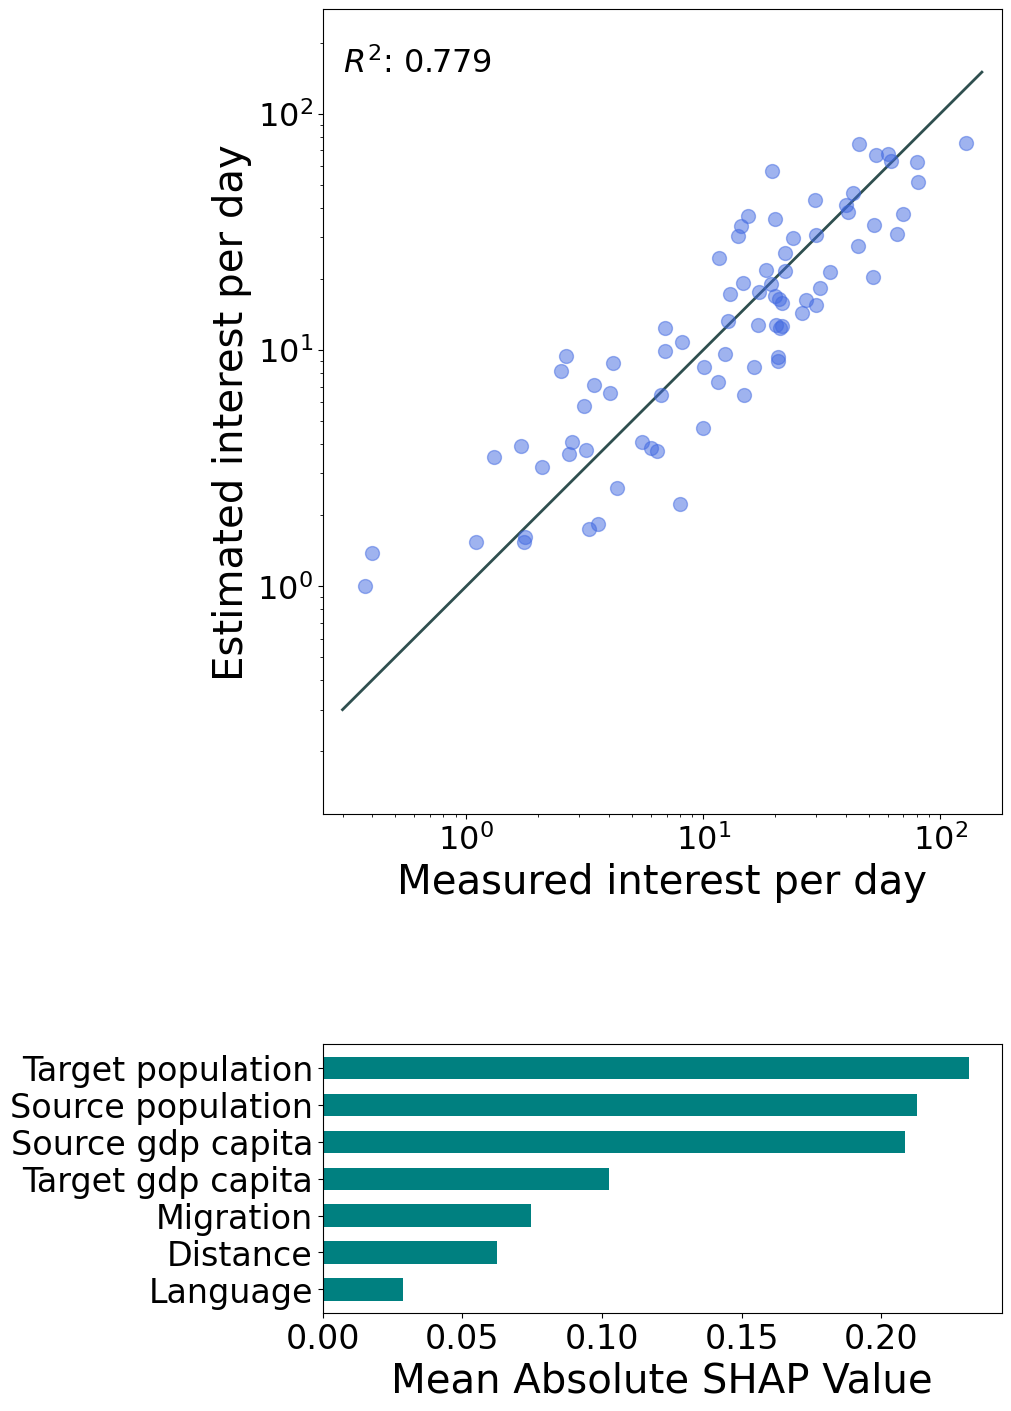

Index(['Target population', 'Source population', 'Source gdp capita',
       'Target gdp capita', 'Migration', 'Distance', 'Language'],
      dtype='object')
[0.23153836544138257 0.21275147645250994 0.20866781765907652
 0.10254311642406781 0.07447360625911012 0.06238926127489408
 0.028911492501875507]


In [ ]:
# params
AREA = 'SA'
low_bound = 0.3
high_bound = 150
x = np.linspace(low_bound, high_bound, high_bound)
low_bound_y = 0.3
high_bound_y = 100

# shap values
masker = X  
explainer = shap.Explainer(mod, masker)
shap_values = explainer(X)
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

# Compute mean absolute SHAP value per feature
shap_mean = shap_df.abs().mean().sort_values(ascending=False)
print(shap_mean)
# Create figure
fig = plt.figure(figsize=(10, 14), constrained_layout=True)  

gs = fig.add_gridspec(nrows=18, ncols=1)  #)
ax1 = fig.add_subplot(gs[:12, 0])
ax2 = fig.add_subplot(gs[14:, 0])

# First subplot
ext_vector = 10 ** extimated_flux_log

ax1.plot(x, x, color='darkslategray', alpha=1, linewidth=2.0)
ax1.loglog(real_vector, ext_vector, '.', color='royalblue', alpha=0.5, markersize=20)

ax1.set_ylim(low_bound_y, high_bound_y)
ax1.text(low_bound, high_bound, r'$R^{2}$: ' + str(round(mod.score(X, y), 3)), size=23)

ax1.set_xlabel('Measured interest per day', fontsize=29)
ax1.set_ylabel('Estimated interest per day', fontsize=29)
ax1.tick_params(axis='both', labelsize=23)
ax1.set_aspect('equal', adjustable='datalim')

# Second subplot
bar_width = 0.6
new_shap_mean_index = shap_mean.index[0:7]
new_shap_mean_values = shap_mean.values[0:7]
new_shap_mean_index_list = list(new_shap_mean_index)
new_shap_mean_index_list[6] = 'Language'
new_shap_mean_index = pd.Index(new_shap_mean_index_list)
#ax2.barh(shap_mean.index[::-1], shap_mean.values[::-1], color='teal', height=bar_width)
ax2.barh(new_shap_mean_index[::-1], new_shap_mean_values[::-1], color='teal', height=bar_width)


ax2.set_xlabel('Mean Absolute SHAP Value', fontsize=29)
ax2.tick_params(axis='both', labelsize=24)

#plt.tight_layout()
file = 'p1_p2_g1_g2_d_lang_m_trans_' + data + f'_gravity_model_{AREA}_new.png'
fig.savefig(parent_dir / 'Data analysis' / 'Gravity model' / 'SA' / file, transparent=False, dpi = 300)
plt.show()